In [2]:
!pip install tensorflow

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from sklearn.preprocessing import StandardScaler

%matplotlib inline

register_matplotlib_converters()

rcParams["figure.figsize"] = 24, 12
RANDOM_SEED = 1

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Reading the data and parsing time values, then turning them into an index for simplicity

In [67]:
data = pd.read_csv("/kaggle/input/pg-1962-2023/PG.csv", parse_dates=["Date"])
df = data[["Date", "Close"]]
df.set_index("Date", inplace=True)
df.head()

,Close
Date,
1962-01-02,1.429688
1962-01-03,1.414063
1962-01-04,1.390625
1962-01-05,1.380859
1962-01-08,1.343750


In [68]:
df.shape

(15504, 1)

The data are stck prices of Procter&Gamble for the period betweeen 1962 and 2023 (august)

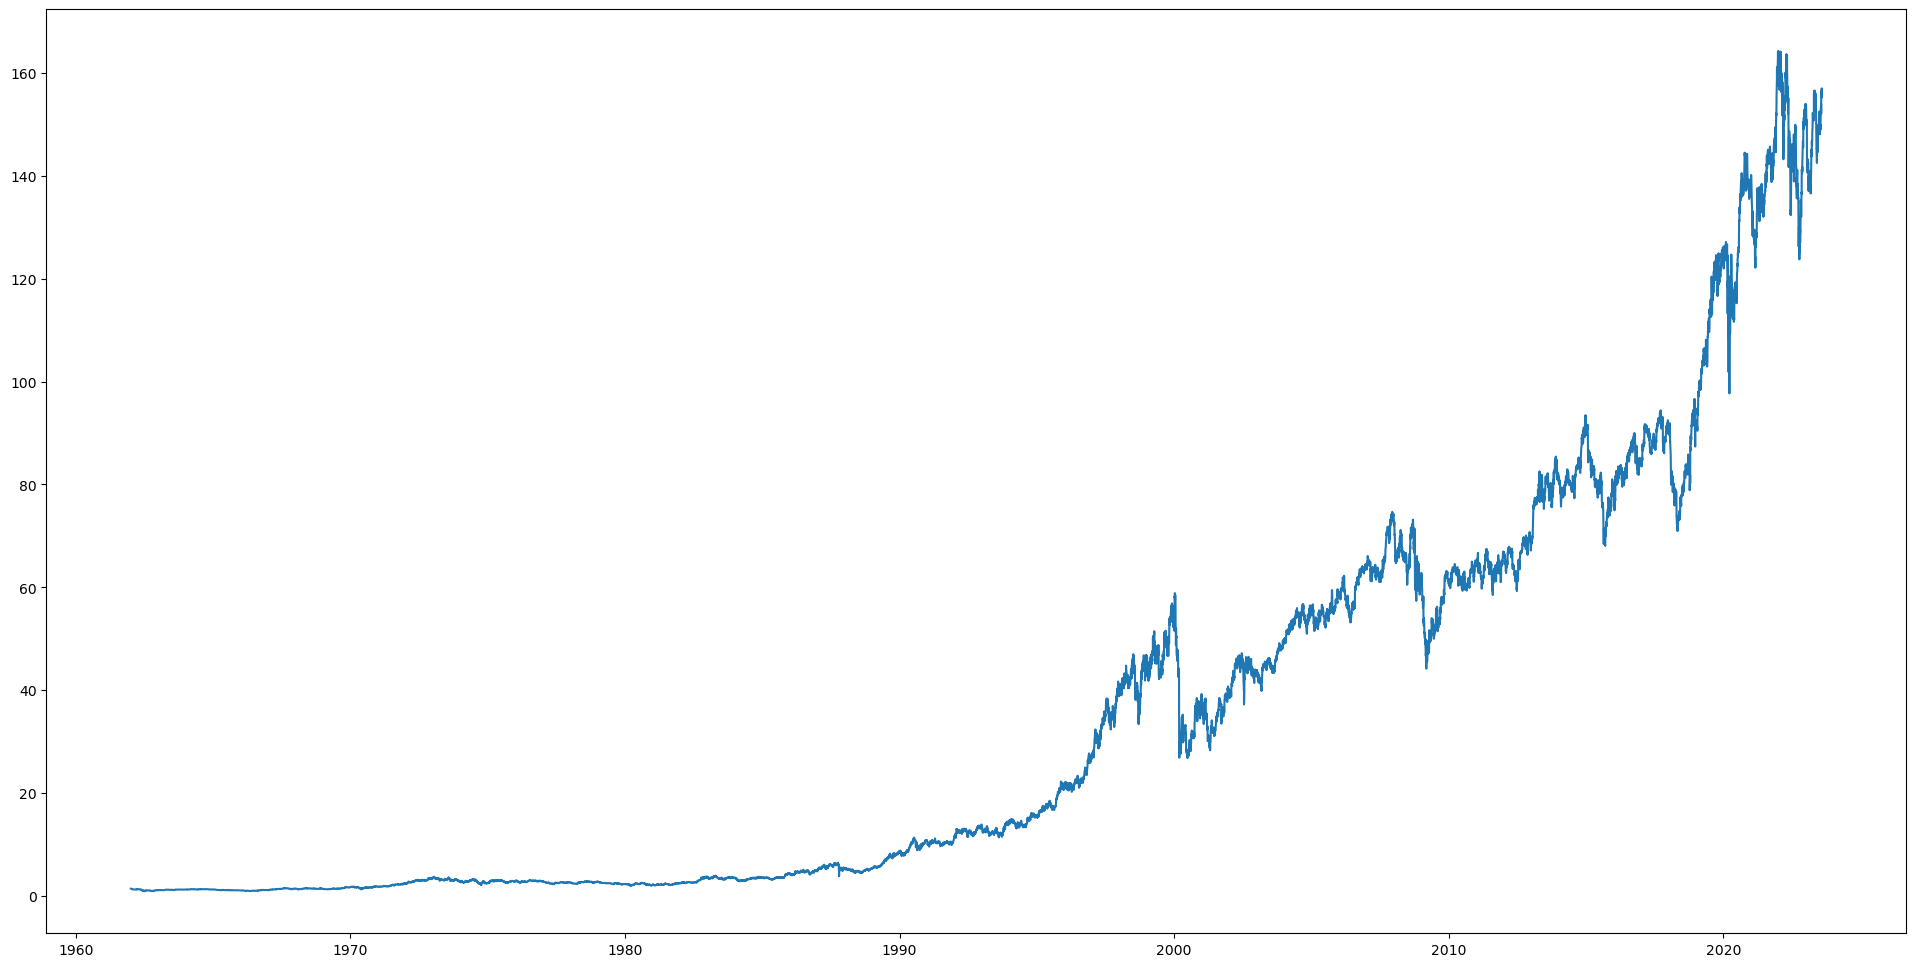

In [4]:
plt.plot(df, label="close price")
plt.show()

The train/test sizes are 80% and 20%

In [70]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)] #cannot train on "future" data

In [71]:
scaler = StandardScaler()
scaler = scaler.fit(train[["Close"]])
train["Close"] = scaler.transform(train[["Close"]])
test["Close"] = scaler.transform(test[["Close"]])

/tmp/ipykernel_28/711609530.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Close"] = scaler.transform(train[["Close"]])
/tmp/ipykernel_28/711609530.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Close"] = scaler.transform(test[["Close"]])


Creating the sequence:

In [72]:
def create_seq(X, y, seq_steps=1):
    X_vals, y_vals = [], []
    for i in range(len(X) - seq_steps):        
        X_vals.append(X.iloc[i:(i+seq_steps)].values)
        y_vals.append(y.iloc[i + seq_steps])
    return np.array(X_vals), np.array(y_vals)

Step = 30, for convenience and monthly values

In [73]:
SEQ_STEPS = 30
X_train, y_train = create_seq(train[["Close"]], train["Close"], SEQ_STEPS)
X_test, y_test = create_seq(test[["Close"]], test["Close"], SEQ_STEPS)

The unit number, dropout rate were chosen experimentally, as well as the number of epochs (10) to avoid overtraining and overfitting

In [74]:
#the model itself - LSTM Autoencoder
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))

model.add(keras.layers.Dropout(rate=0.3))

model.add(keras.layers.RepeatVector(n=X_train.shape[1]))

model.add(keras.layers.LSTM(
    units=64, 
    return_sequences=True
))

model.add(keras.layers.Dropout(rate=0.3))

model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))

model.compile(loss="mae", optimizer="adam")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 30, 64)           0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_3 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 1)            65        
 tributed)                                            

In [75]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/10
348/348 [==============================] - 7s 10ms/step - loss: 0.1226 - val_loss: 0.1658
Epoch 2/10
348/348 [==============================] - 3s 8ms/step - loss: 0.1026 - val_loss: 0.1655
Epoch 3/10
348/348 [==============================] - 3s 8ms/step - loss: 0.0841 - val_loss: 0.2040
Epoch 4/10
348/348 [==============================] - 3s 8ms/step - loss: 0.0848 - val_loss: 0.1654
Epoch 5/10
348/348 [==============================] - 3s 8ms/step - loss: 0.0823 - val_loss: 0.1730
Epoch 6/10
348/348 [==============================] - 3s 8ms/step - loss: 0.0781 - val_loss: 0.1627
Epoch 7/10
348/348 [==============================] - 3s 8ms/step - loss: 0.0808 - val_loss: 0.1641
Epoch 8/10
348/348 [==============================] - 3s 9ms/step - loss: 0.0766 - val_loss: 0.1621
Epoch 9/10
348/348 [==============================] - 3s 8ms/step - loss: 0.0792 - val_loss: 0.1683
Epoch 10/10
348/348 [==============================] - 3s 8ms/step - loss: 0.0790 - val_loss: 0.173

Optimal training vs validation loss for this dataset

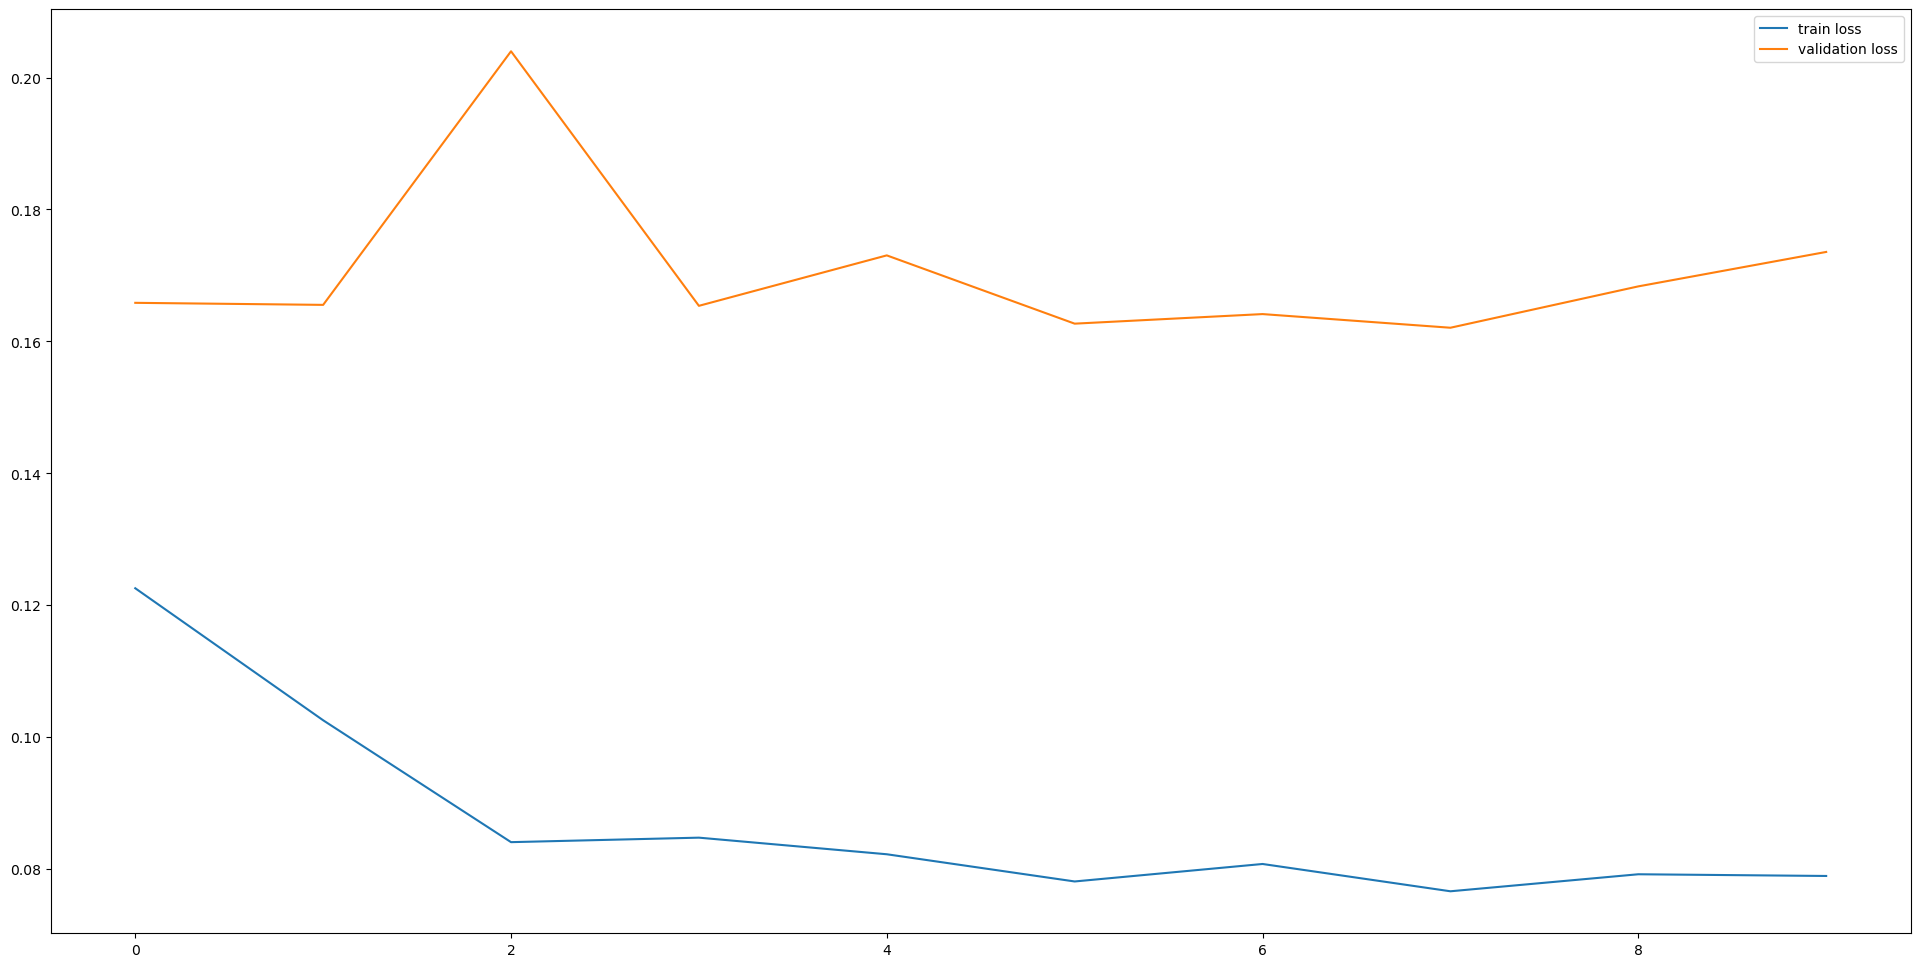

In [76]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

In [77]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

387/387 [==============================] - 2s 3ms/step


Does not reflect the actual loss, so threshold is later chosen in proportion 90/10

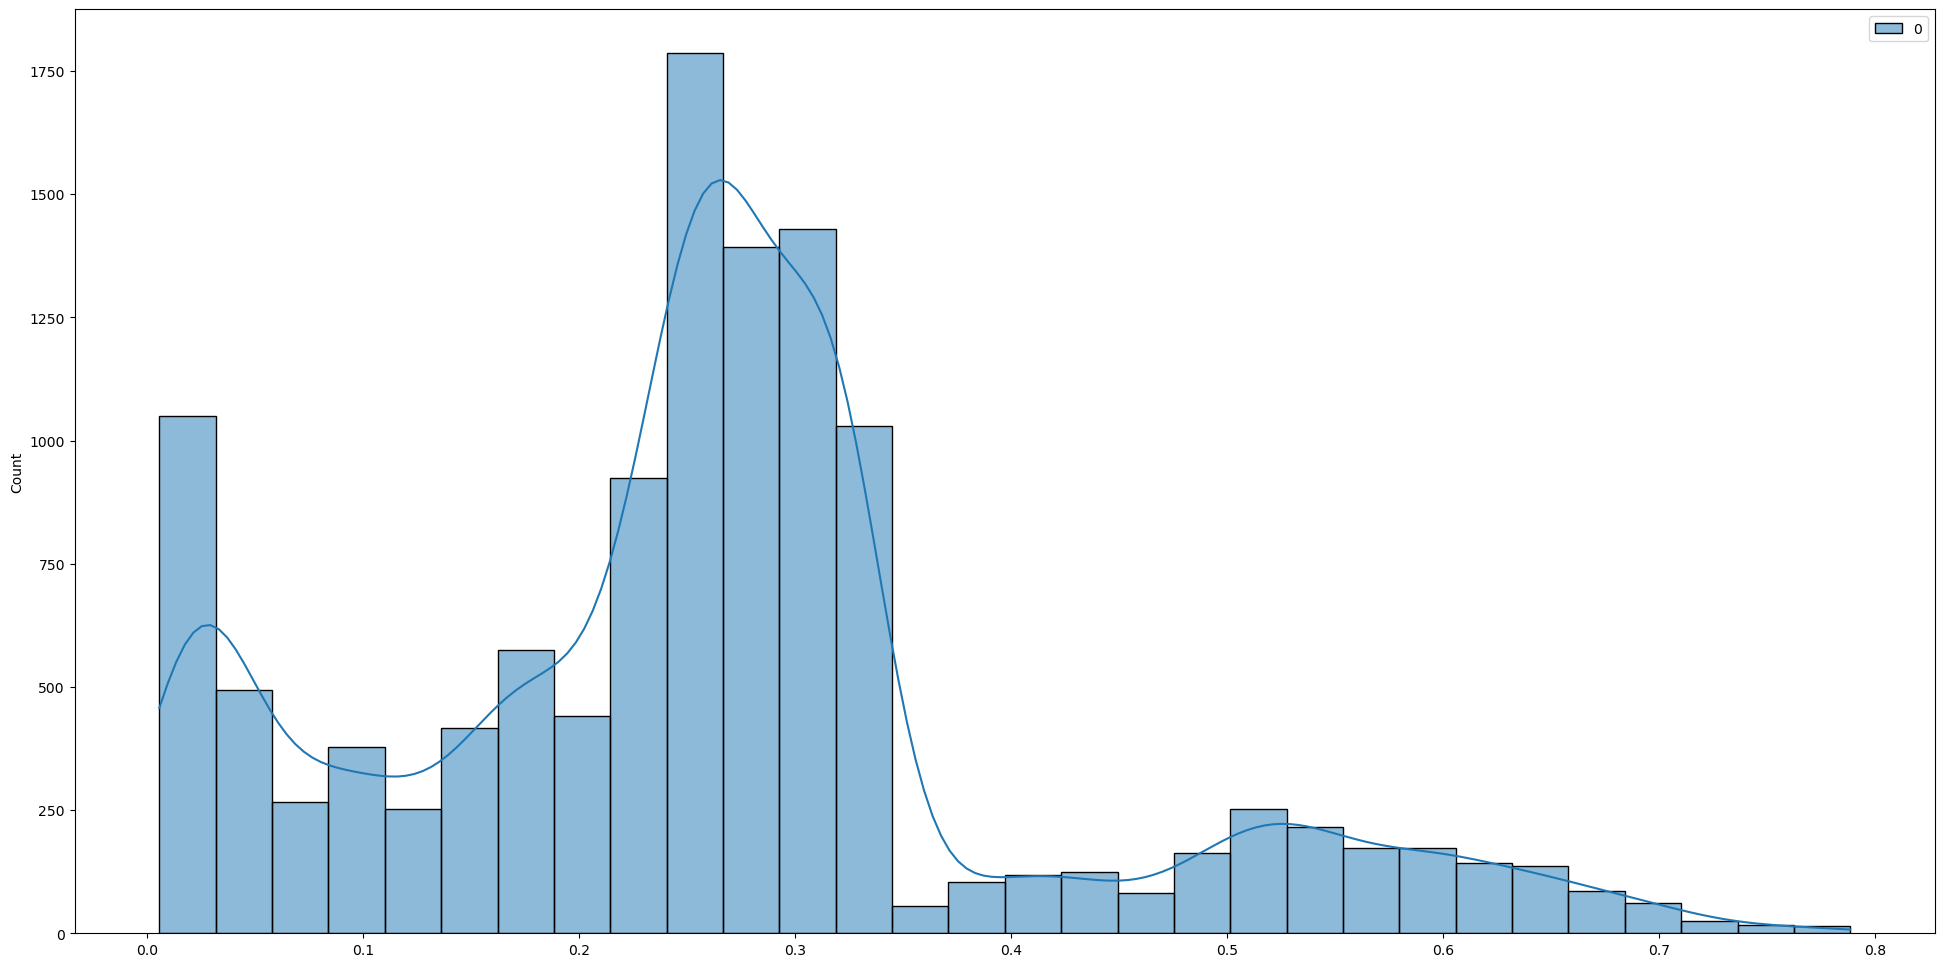

In [78]:
sns.histplot(train_mae_loss, bins=30, kde=True)
plt.show()

In [79]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
THRESHOLD = test_mae_loss.max() * 0.9

96/96 [==============================] - 0s 3ms/step


In [80]:
test_score_df = pd.DataFrame(index=test[SEQ_STEPS:].index)
test_score_df["loss"] = test_mae_loss
test_score_df["threshold"] = THRESHOLD
test_score_df["anomaly"] = test_score_df.loss > test_score_df.threshold
test_score_df["close"] = test[SEQ_STEPS:]["Close"]

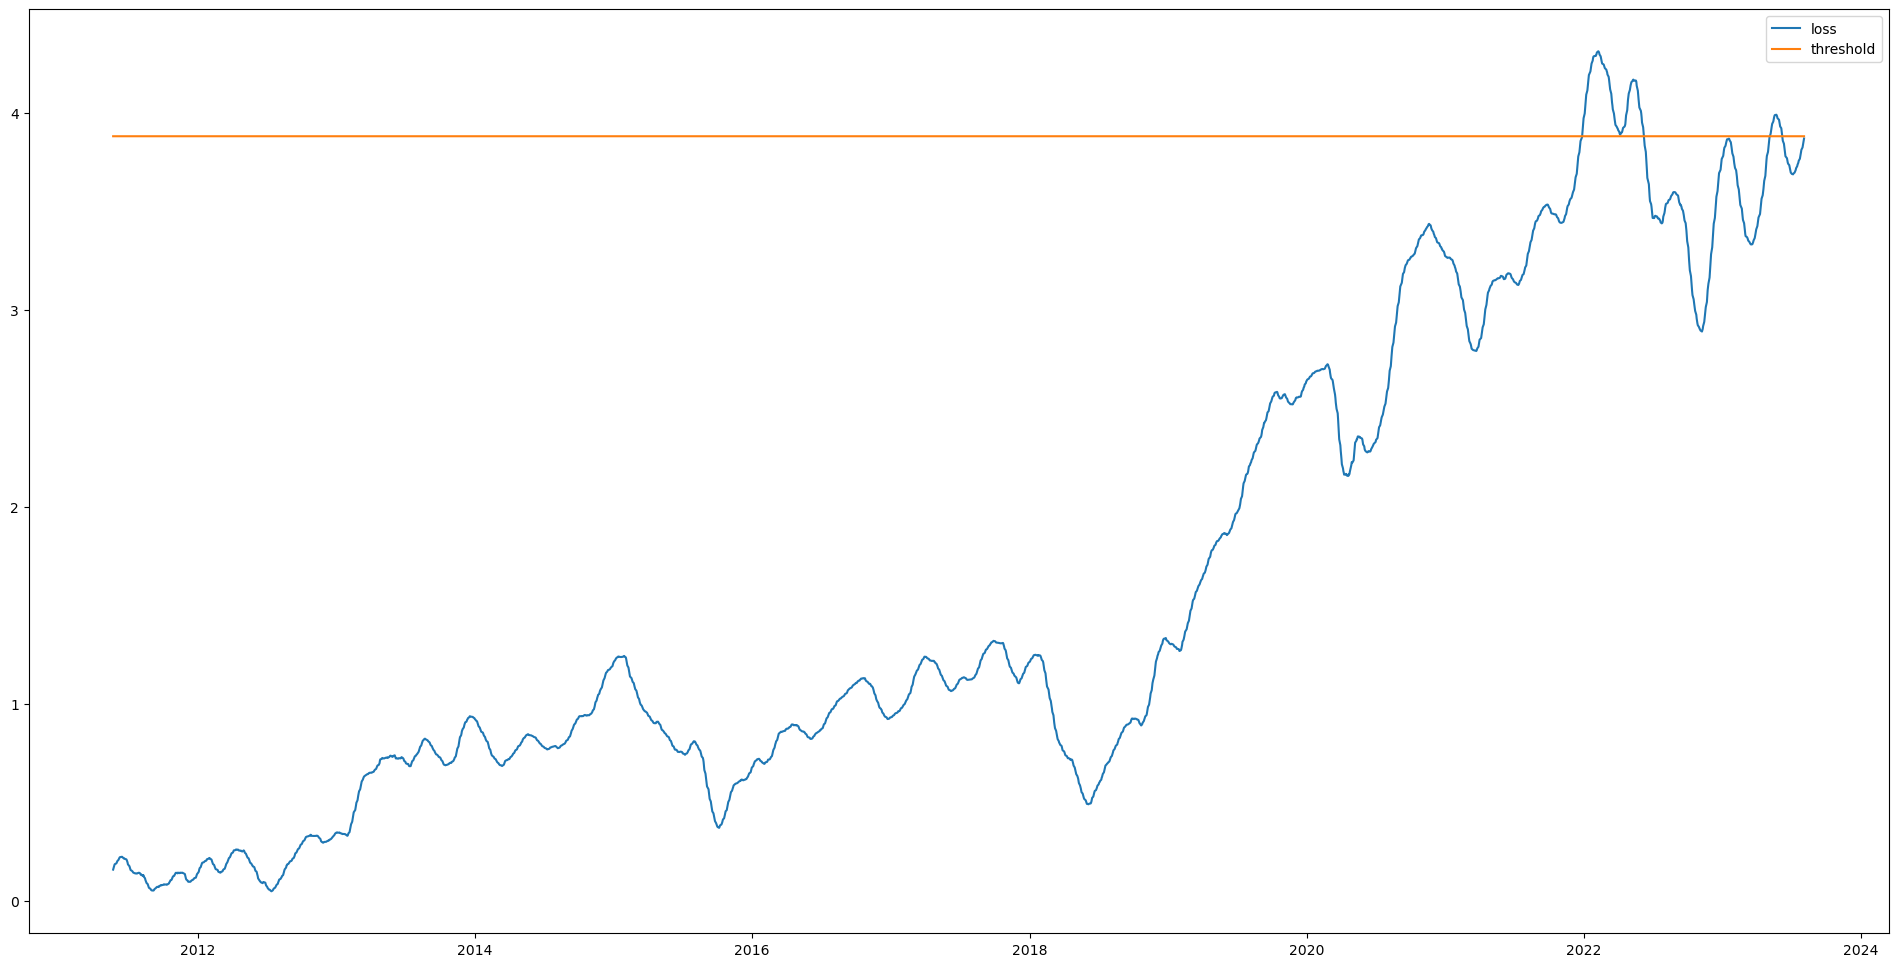

In [6]:
plt.plot(test_score_df.index, test_score_df.loss, label="loss")
plt.plot(test_score_df.index, test_score_df.threshold, label="threshold")
plt.legend()
plt.show()

In [82]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
Date,,,,
2021-12-28,3.899846,3.881977,True,6.622363
2021-12-29,3.924052,3.881977,True,6.684150
2021-12-30,3.948616,3.881977,True,6.619160
2021-12-31,3.973392,3.881977,True,6.656232
2022-01-03,3.997731,3.881977,True,6.625109


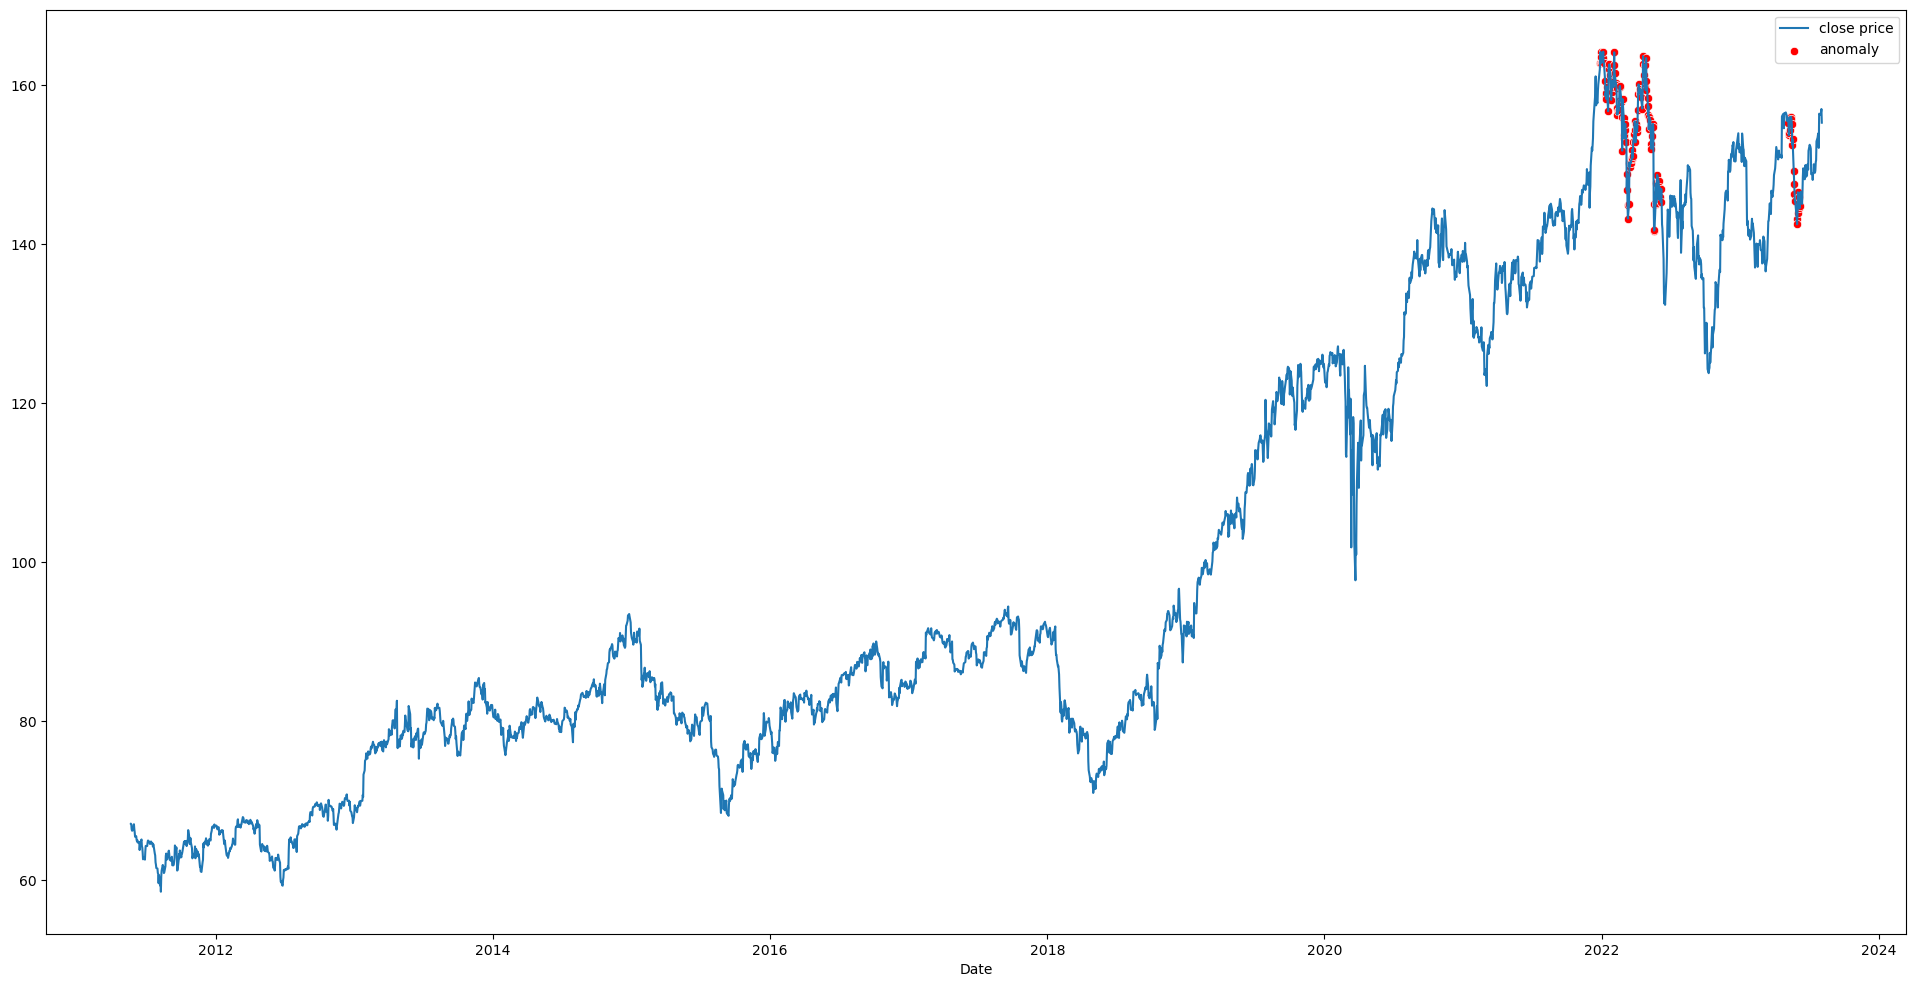

In [5]:
anomalies_close = anomalies[["close"]].values.flatten()
anomalies_close = anomalies_close.reshape(-1, 1)
anomalies_close = scaler.inverse_transform(anomalies_close)

plt.plot(test[SEQ_STEPS:].index, 
         scaler.inverse_transform(test[SEQ_STEPS:][["Close"]]), 
         label='close price')

anomalies_close = anomalies_close.flatten()
sns.scatterplot(x=anomalies.index, 
                y=anomalies_close, 
                color='r', 
                label='anomaly'
               )
plt.legend()
plt.show()

Most anomalies detected are noticeable in the recent times (2021 - ...), likely due to Covid-19 and market instability (the Ukraine conflict).